# Validation Extension: Bayesian Curve and SABR Uncertainty Bands

**Goal:** using the *same demo inputs* exported from Notebook 01 (via `outputs/demo_data.npz`), we fit:

- a **Nelson–Siegel (NS)** or **Nelson–Siegel–Svensson (NSS)** zero curve and compute a **95% credible band**
- a **SABR implied-vol smile** (Hagan approximation) and compute a **95% credible band**

We also illustrate how uncertainty can flow **curve → forward → smile**. In the **demo-data path**, we keep the forward fixed to validate SABR cleanly. In the **synthetic-data path**, we propagate curve uncertainty into the forward to demonstrate the full chain.

Reproducible research configuration and separation of concerns:
- Notebook 01 focuses on **FO implementation/performance**.
- This notebook focuses on **validation + uncertainty quantification** (Bayesian inference + diagnostics).

In [1]:
# Housekeeping: to run under bayes-env
import os 
os.environ["PYTENSOR_FLAGS"] = "cxx=,mode=FAST_COMPILE,linker=py"
for k in ("LDFLAGS","CFLAGS","CPPFLAGS","BLAS","BLAS_LDFLAGS","ATLAS","MKL"): # Remove stray build flags
    os.environ.pop(k, None)
os.environ.pop("MPLBACKEND", None)

import numpy as np
import pandas as pd
from IPython.display import display
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from pytensor import config
print("PyTensor config:", "cxx=", repr(config.cxx), "mode=", config.mode, "linker=", config.linker)
from pathlib import Path 
import arviz as az
from arviz.labels import MapLabeller
[k for k in az.rcParams.keys() if "plot" in k and "trace" in k]

PyTensor config: cxx= '' mode= FAST_COMPILE linker= py


[]

## 1) Model definitions and notations

For maturity $\tau$ (years), the Nelson–Siegel (NS) zero yield is:
$$
y(\tau) = \beta_0
+ \beta_1 \left(\frac{1-e^{-\lambda \tau}}{\lambda \tau}\right)
+ \beta_2 \left(\frac{1-e^{-\lambda \tau}}{\lambda \tau} - e^{-\lambda \tau}\right)
$$
We parameterize $\lambda>0$ via $\lambda=\exp(\log\lambda)$ to enforce positivity.

Nelson–Siegel–Svensson (NSS) adds a second curvature term (often improving flexibility):
$$
y(\tau) = \beta_0 + \beta_1 x(\tau;\lambda_1) + \beta_2\bigl(x(\tau;\lambda_1)-e^{-\tau/\lambda_1}\bigr)
+ \beta_3\bigl(x(\tau;\lambda_2)-e^{-\tau/\lambda_2}\bigr)
$$
with $x(\tau;\lambda)=\frac{1-e^{-\tau/\lambda}}{\tau/\lambda}$ and $\lambda_1,\lambda_2>0$.

For observed zero yields $\{y^{\text{obs}}_i\}$ at maturities $\{\tau_i\}$, we use a Student-$t$ likelihood:
$$
y^{\text{obs}}_i \sim t_\nu\left(\mu_i,\; s_i\right),\qquad
\mu_i = y(\tau_i;\theta)
$$
This is robust to outliers / bid–ask noise compared with a strict Gaussian likelihood.

We fit a SABR smile for a single expiry $T$ using the Hagan implied-vol approximation:
$$
\sigma_{\text{BS}}(F,K,T) \approx \frac{\alpha}{(F K)^{(1-\beta)/2}} \cdot \frac{z}{x(z)} \cdot \Bigl(1 + \mathcal{O}(T)\Bigr)
$$
where
$$
z = \frac{\nu}{\alpha}(F K)^{(1-\beta)/2}\ln(F/K),\quad
x(z)=\ln\left(\frac{\sqrt{1-2\rho z+z^2}+z-\rho}{1-\rho}\right)
$$
We enforce constraints via smooth transforms:
$\alpha=\exp(\log\alpha)>0$, $\nu=\exp(\log\nu)>0$, and $\rho=\tanh(\rho_{\text{uncon}})\in(-1,1)$

The above mapping, from parameters to observables, provides defensible inference and meaningful diagnostics (trace, ESS, $\hat R$).

In [2]:
def NS_zero(tau, beta0, beta1, beta2, lam):
    """Nelson–Siegel zero yield y(tau). tau in years."""
    tau  = np.asarray(tau, dtype=float)
    x    = np.where(tau==0.0, 1.0, (1 - np.exp(-lam*tau))/(lam*tau))
    return beta0 + beta1 * x + beta2 * (x - np.exp(-lam*tau))

def NSS_zero(tau, beta0, beta1, beta2, beta3, lam1, lam2):
    """NSS zero yield y(tau)."""
    tau = np.asarray(tau, dtype=float)
    x1  = np.where(tau==0.0, 1.0, (1 - np.exp(-tau/lam1)) / (tau/lam1))
    x2  = x1 - np.exp(-tau/lam1)
    x3  = np.where(tau==0.0, 1.0, (1 - np.exp(-tau/lam2)) / (tau/lam2)) - np.exp(-tau/lam2)
    return beta0 + beta1*x1 + beta2*x2 + beta3*x3

def discount_from_zero(tau, y):
    """P(0,tau) from zero yield y(tau) (cont comp)."""
    return np.exp(-y * tau)

def sabr_vol_hagan(F, K, T, alpha, beta, rho, nu):
    """ Hagan SABR implied vol """
    eps = 1e-12
    K   = np.atleast_1d(np.asarray(K, float))
    F   = np.broadcast_to(np.asarray(F, float), K.shape)
    T   = float(T)

    FK = F*K
    logFK   = np.log(np.maximum(F, eps)/np.maximum(K, eps))
    fk_beta = FK ** ((1.0 - beta)/2.0)
    z = (nu/alpha) * fk_beta * logFK
    sqrt_term = np.sqrt(np.maximum(1.0 - 2.0*rho*z + z*z, eps))
    xz = np.log((sqrt_term + z - rho)/(1.0 - rho + eps))

    A = 1.0 + ((1-beta)**2/24.0)*logFK**2 + ((1-beta)**4/1920.0)*logFK**4
    B = 1.0 + ( ((1-beta)**2/24.0)*(alpha**2)/(fk_beta**2 + eps)
              + (rho*beta*nu*alpha)/(4.0*(fk_beta + eps))
              + ((2.0 - 3.0*rho**2)/24.0)*(nu**2) ) * T

    sigma = (alpha/(fk_beta*A + eps)) * (z/(xz + eps)) * B

    # ATM branch
    atm = np.isclose(K, F, atol=1e-12)
    if np.any(atm):
        F_atm = F[atm]
        sigma_atm = (alpha/(np.power(F_atm, 1.0-beta) + eps)) * (
            1.0 + ( ((1-beta)**2/24.0)*(alpha**2)/(np.power(F_atm, 2.0-2.0*beta) + eps)
                  + (rho*beta*nu*alpha)/(4.0*(np.power(F_atm, 1.0-beta) + eps))
                  + ((2.0 - 3.0*rho**2)/24.0)*(nu**2) ) * T
        )
        sigma = np.array(sigma, copy=True)
        sigma[atm] = sigma_atm

    return np.maximum(sigma, 1e-6)

## 2) Data: load the exported demo NPZ (preferred) or generate synthetic data

Notebook 01 exports `outputs/demo_data.npz` containing:

- `taus`: maturity grid (years)
- `y`: yield panel (shape `(T, n_tau)`)
- `Tmat`, `Fwd`: SABR expiry and forward used by the demo
- `K`, `vols`: strikes and observed implied vols

If the NPZ is not present, this notebook falls back to a synthetic example so it remains runnable in isolation.

`use_demo_data == True` when you are validating against Notebook 01.

In [3]:
# ---------------------------
# DATA: load demo data if available (recommended), otherwise generate synthetic
# ---------------------------
repo_root = Path.cwd() # Detect repo root (so relative paths work whether you run from repo root or notebooks/)
for p in [repo_root] + list(repo_root.parents):
    if (p / "pyproject.toml").exists() or (p / "CMakeLists.txt").exists() or (p / ".git").exists():
        repo_root = p
        break

demo_file = repo_root / "outputs" / "demo_data.npz"
use_demo_data = demo_file.exists()

if use_demo_data:
    d = np.load(demo_file, allow_pickle=True)
    # Curve cross-section from the C++ demo notebook
    maturities = d["taus"].astype(float)
    y_panel = d["y"].astype(float)          # shape (T, n_tau)
    y_obs = y_panel[0].astype(float)        # cross-section at t=0 (use y_panel.mean(0) if preferred)
    # Measurement noise scale (bps): demo uses ~0.0005 in generation
    s_tau = np.full_like(y_obs, 0.0005)

    # SABR smile inputs from the C++ demo notebook
    T_sabr = float(d["Tmat"])
    F_true = float(d["Fwd"])
    Ks = d["K"].astype(float)
    vol_obs = d["vols"].astype(float)
    s_i = np.full_like(vol_obs, 0.0002)

    # No curve→forward propagation in the demo-data path (kept simple/clean)
    S0 = None
else:
    # (A) Curve quotes for NS/NSS (zero yields, in decimals)
    maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30], float)
    true_ns = dict(beta0=0.025, beta1=-0.010, beta2=0.005, lam=0.8)
    y_true  = NS_zero(maturities, **true_ns)
    np.random.seed(7)
    y_obs   = y_true + np.random.standard_t(df=6, size=maturities.size)*0.0008  # ~8 bps noise
    s_tau   = np.full_like(y_obs, 0.0008)  # tenor noise scales (could be bid-ask)

    # (B) SABR option smiles at a single expiry T using an underlying forward tied to curve
    T_sabr  = 2.0  # years expiry
    S0      = 100.0
    # For synthetic truth, use curve's zero at T to set forward (equity-style F = S0 * exp(r T))
    y_T_true = NS_zero(T_sabr, **true_ns)
    F_true   = S0*np.exp(y_T_true*T_sabr)
    Ks       = np.array([60, 70, 80, 90, 95, 100, 105, 110, 120, 140], float)
    true_sabr = dict(alpha=0.22, beta=0.5, rho=-0.25, nu=0.6)
    vol_true  = sabr_vol_hagan(F_true, Ks, T_sabr, **true_sabr)
    np.random.seed(13)
    vol_obs   = vol_true + np.random.standard_t(df=5, size=Ks.size)*0.002
    s_i       = np.full_like(vol_obs, 0.002)  # 20 bps vol noise

In [4]:
# Quick visibility into what data path we are using (DEMO vs SYNTHETIC)
if use_demo_data:
    print("Using DEMO data from:", demo_file)
    print("keys:", d.files)
    for k in d.files:
        a = d[k]
        print(f"{k:>8s}  shape={getattr(a,'shape',None)}  dtype={getattr(a,'dtype',None)}")
else:
    print("DEMO data not found; using SYNTHETIC data.")
    print("Synthetic curve maturities:", maturities.shape)
    print("Synthetic curve y_obs:", y_obs.shape)
    print("Synthetic smile Ks:", Ks.shape, "vol_obs:", vol_obs.shape)


DEMO data not found; using SYNTHETIC data.
Synthetic curve maturities: (11,)
Synthetic curve y_obs: (11,)
Synthetic smile Ks: (10,) vol_obs: (10,)


## 2.1 Data inspection and target selection (curve and smile)

Make shapes explicit and define the targets used in inference.

- Curve data is typically a panel $y[t,\tau]$. We fit a **cross-section**:
  $$
  y^{\text{obs}}(\tau_i) \equiv y[t_0,\tau_i]
  $$
  where $t_0=0$ by default. (Alternative: use the time-average $ \bar y(\tau)=\frac{1}{T}\sum_t y[t,\tau] $ for a smoother target.)

- Smile data is a single-expiry cross-section: $\{(K_j,\sigma^{\text{obs}}_j)\}_{j=1}^m$.

After running the next sections, confirm
- `maturities.shape == (n_tau,)`
- `y_obs.shape == (n_tau,)`
- `Ks.shape == (m,)` and `vol_obs.shape == (m,)`

Hence validating *cross-sectional* curve and smile fits consistent with the FO “snapshot” use case in Notebook 01.


## 3) Bayesian curve fit (NS or NSS) and curve credible bands

Infer a posterior distribution over curve parameters $\theta$ (NS or NSS) and convert it into a **distribution of curves** $y(\tau)$. From that distribution we compute credible bands (e.g., 5/50/95 percentiles).

After running the next cell, confirm
- **Diagnostics:** ideally 0 divergences; $\hat R \lesssim 1.01$; reasonable ESS.
- **Trace behavior:** chains overlap and are stationary.
  - Note: $\lambda$ (and curvature) can be weakly identified in NS/NSS, so $\lambda$ may show skew/heavy tails (this is common and not automatically “wrong”).
- **Outputs created:** `zero_q05`, `zero_q50`, `zero_q95` on `tau_grid`, and forward draws `F_draws`.

Hence demonstrating (relative to Notebook 01)
- A statistically defensible curve fit that yields a **central estimate** plus **uncertainty bands**.
- A validation layer: deterministic outputs from Notebook 01 should align with the posterior median and/or fall within the credible band for most tenors.


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.09        3            21.93 draws/s    0:02:16   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.08        27           22.14 draws/s    0:02:15   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.10        31           20.28 draws/s    0:02:27   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.08        15           22.02 draws/s    0:02:16   0:00:00

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 158 seconds.


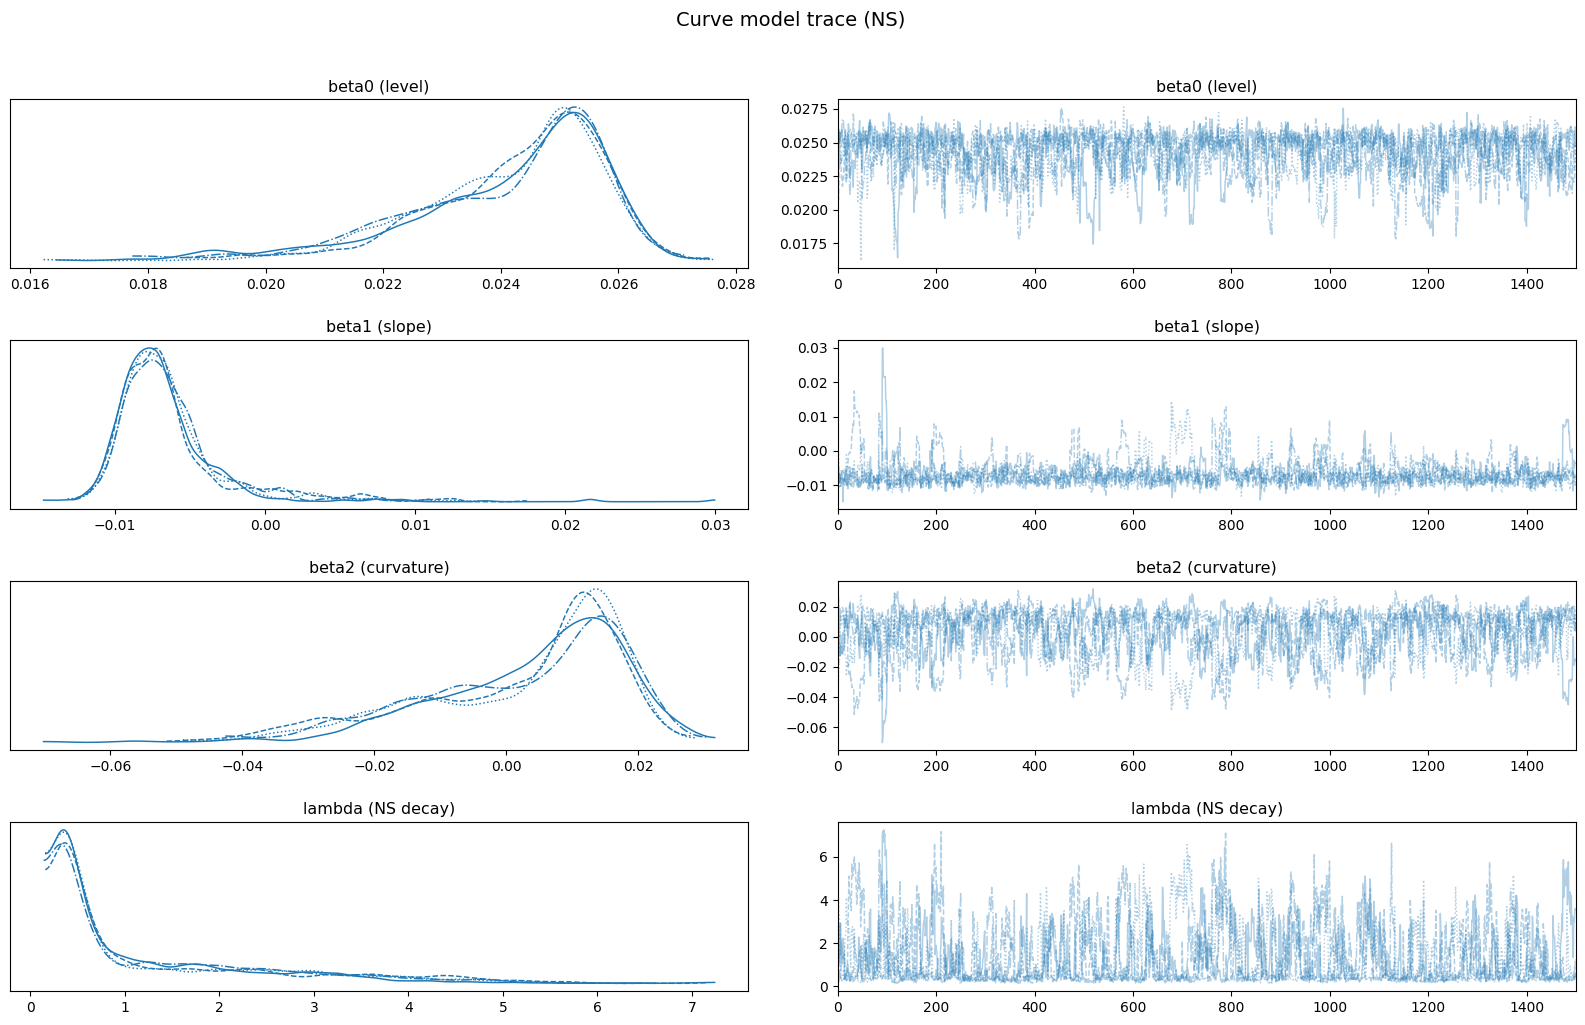

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.0242,0.0016,0.0212,0.0265,0.0001,0.0001,580.8135,722.8540,1.0058
beta1,-0.0065,0.0036,-0.0116,-0.0002,0.0002,0.0003,664.3822,354.1763,1.0052
beta2,0.0029,0.0150,-0.0273,0.0242,0.0008,0.0006,407.5655,350.1435,1.0034
log_lam,-0.2576,0.9446,-1.5732,1.4445,0.0467,0.0204,430.5811,493.0078,1.0026
lam,1.2307,1.2671,0.1486,3.7956,0.0650,0.0599,430.5811,493.0078,1.0026


In [5]:
use_nss = False  # <- flip to True to use NSS

with pm.Model() as curve_model:
    # Priors (weakly-informative)
    beta0 = pm.Normal("beta0", mu=0.02, sigma=0.02)   # long-run level ~2%
    beta1 = pm.Normal("beta1", mu=0.00, sigma=0.03)   # slope
    beta2 = pm.Normal("beta2", mu=0.00, sigma=0.03)   # curvature
    if use_nss:
        beta3 = pm.Normal("beta3", mu=0.00, sigma=0.03)
        log_lam1 = pm.Normal("log_lam1", mu=np.log(1.0), sigma=0.7)
        log_lam2 = pm.Normal("log_lam2", mu=np.log(2.0), sigma=0.7)
        lam1 = pm.Deterministic("lam1", pm.math.exp(log_lam1))
        lam2 = pm.Deterministic("lam2", pm.math.exp(log_lam2))
    else:
        log_lam = pm.Normal("log_lam", mu=np.log(1.0), sigma=0.7)
        lam     = pm.Deterministic("lam", pm.math.exp(log_lam))

    # Deterministic mean zeros at observed maturities
    tau_c = pm.math.constant(maturities)
    if use_nss:
        # NSS basis in pm.math
        x1 = pm.math.switch(pm.math.eq(tau_c, 0.0), 1.0, (1 - pm.math.exp(-tau_c/lam1)) / (tau_c/lam1))
        x2 = x1 - pm.math.exp(-tau_c/lam1)
        x3 = pm.math.switch(pm.math.eq(tau_c, 0.0), 1.0, (1 - pm.math.exp(-tau_c/lam2)) / (tau_c/lam2)) - pm.math.exp(-tau_c/lam2)
        mu_y = beta0 + beta1*x1 + beta2*x2 + beta3*x3
    else:
        x  = pm.math.switch(pm.math.eq(tau_c, 0.0), 1.0, (1 - pm.math.exp(-lam*tau_c)) / (lam*tau_c))
        mu_y = beta0 + beta1*x + beta2*(x - pm.math.exp(-lam*tau_c))

    s_obs = pm.math.constant(s_tau)
    pm.StudentT("y_obs", nu=6, mu=mu_y, sigma=s_obs, observed=y_obs)

    idata_curve = pm.sample(draws=1500,tune=1500,chains=4,cores=4,target_accept=0.9,random_seed=11,progressbar=True)
    labeller_curve = MapLabeller(var_name_map={"beta0": "beta0 (level)","beta1": "beta1 (slope)",
                                               "beta2": "beta2 (curvature)","lam":   "lambda (NS decay)"})

    ax = az.plot_trace( idata_curve,var_names=["beta0", "beta1", "beta2", "lam"],compact=True,labeller=labeller_curve)
    fig = plt.gcf()
    fig.set_size_inches(16, 10)
    plt.suptitle("Curve model trace (NS)", y=1.02, fontsize=14)
    plt.tight_layout(h_pad=2.0, w_pad=1.5)
    outdir = Path(repo_root) / "outputs" / "figures"
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / "trace_curve_ns.png", dpi=200, bbox_inches="tight")
    plt.show() 
    
#print(az.summary(idata_curve, var_names=[v for v in idata_curve.posterior.data_vars if v!="y_obs"], round_to=4))
summ = az.summary(idata_curve, var_names=["beta0","beta1","beta2","log_lam","lam"], round_to=4)
with pd.option_context("display.width", 2000,"display.max_columns", None,
                       "display.max_colwidth", None,"display.expand_frame_repr", False):
    display(summ)
    
# Build posterior zero curves on a plotting grid
tau_grid = np.linspace(0.1, 30.0, 120)
post = idata_curve.posterior
def draw_zero_curves(n=400):
    """Return n posterior draws of zero curves on tau_grid."""
    idx_c = np.linspace(0, post.sizes["chain"]*post.sizes["draw"] - 1, n, dtype=int)
    zeros = []
    if use_nss:
        b0 = post["beta0"].stack(s=("chain","draw")).values
        b1 = post["beta1"].stack(s=("chain","draw")).values
        b2 = post["beta2"].stack(s=("chain","draw")).values
        b3 = post["beta3"].stack(s=("chain","draw")).values
        l1 = post["lam1"].stack(s=("chain","draw")).values
        l2 = post["lam2"].stack(s=("chain","draw")).values
        for j in idx_c:
            zeros.append(NSS_zero(tau_grid, float(b0.flat[j]), float(b1.flat[j]),
                                  float(b2.flat[j]), float(b3.flat[j]),
                                  float(l1.flat[j]), float(l2.flat[j])))
    else:
        b0 = post["beta0"].stack(s=("chain","draw")).values
        b1 = post["beta1"].stack(s=("chain","draw")).values
        b2 = post["beta2"].stack(s=("chain","draw")).values
        l  = post["lam"].stack(s=("chain","draw")).values
        for j in idx_c:
            zeros.append(NS_zero(tau_grid, float(b0.flat[j]), float(b1.flat[j]),
                                 float(b2.flat[j]), float(l.flat[j])))
    return np.array(zeros)

zero_curves = draw_zero_curves(n=400)
zero_q05 = np.percentile(zero_curves, 5, axis=0)
zero_q50 = np.percentile(zero_curves, 50, axis=0)
zero_q95 = np.percentile(zero_curves, 95, axis=0)

# Forward draws used in the SABR section
# - If we loaded the C++ demo data, we keep the forward fixed at the demo Fwd (clean validation of SABR only).
# - Otherwise (synthetic NS/NSS example), we propagate curve uncertainty into the forward via r(T).
if use_demo_data:
    F_draws = np.full(400, float(F_true))
else:
    # Derive a posterior for the forward level used by SABR (equity-style F = S0 * exp(r_T * T))
    # r_T is the posterior zero at T_sabr
    def sample_forward_from_curve(T, S0, n=400):
        idx_c = np.linspace(0, zero_curves.shape[0]-1, n, dtype=int)
        F_list = []
        for j in idx_c:
            # get r_T from the j-th zero curve (interp)
            r_T = np.interp(T, tau_grid, zero_curves[j])
            F_list.append(S0 * np.exp(r_T * T))
        return np.array(F_list)

    F_draws = sample_forward_from_curve(T_sabr, S0, n=400)


## 4) Bayesian SABR fit and smile credible bands

Next, infer a posterior distribution over SABR parameters $(\alpha,\beta,\rho,\nu)$ for a single expiry $T$ and produce **credible bands** for implied vol across strikes.

Implementation details:
- Hagan implied-vol approximation
- robust Student-$t$ likelihood
- extra noise term $\sigma_{\epsilon}$ to capture misfit

Forward handling:
- **Demo-data path:** $F$ fixed at the demo forward `Fwd` (clean validation of SABR parameter uncertainty).
- **Synthetic path:** forward draws $F$ come from the curve posterior (curve → forward → smile).

After running the next cell, confirm
- **Diagnostics:** 0 divergences preferred; trace plots stable; $\hat R$ close to 1.
- **Outputs created:** `smile_q05`, `smile_q50`, `smile_q95`.

So (relative to Notebook 01)
- An uncertainty-aware version of “SABR calibration”: not only a point estimate, but a distribution over smiles.
- A natural FO extension: credible bands provide robustness context for pricing/risk decisions.


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.35        15           23.21 draws/s    0:02:09   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.40        7            22.53 draws/s    0:02:13   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.38        7            23.33 draws/s    0:02:08   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.39        11           23.81 draws/s    0:02:05   0:00:00

Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 145 seconds.


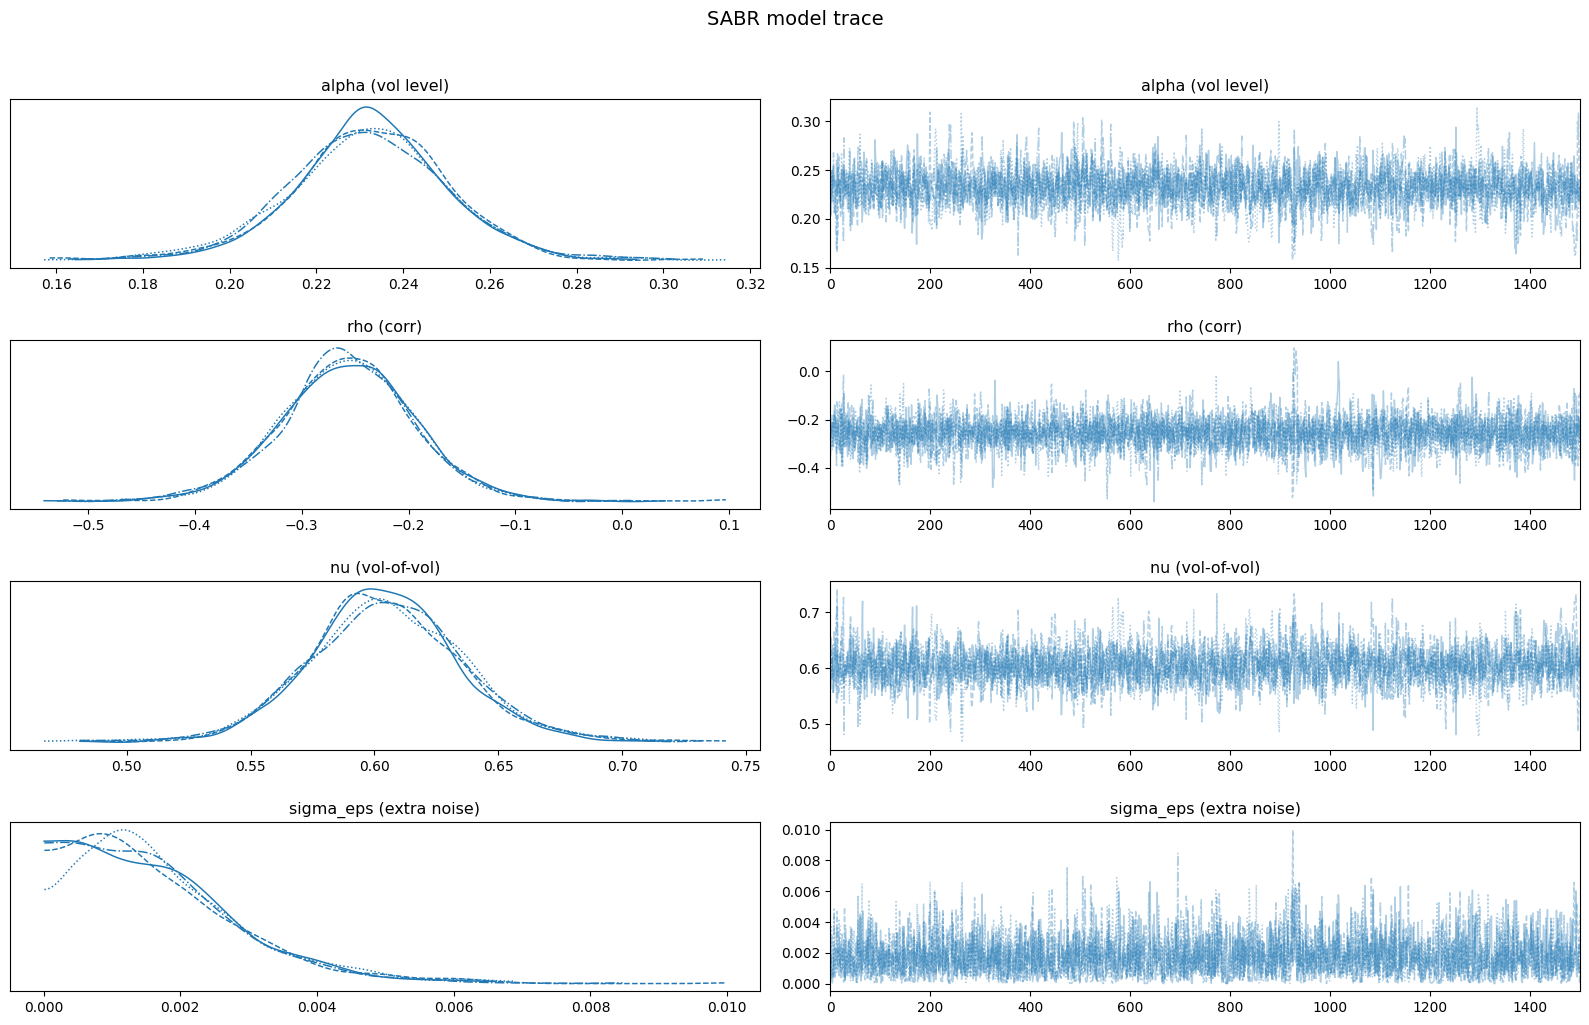

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.2323,0.0187,0.1971,0.2679,0.0004,0.0004,2302.2846,2097.5186,1.0026
rho,-0.2570,0.0640,-0.3762,-0.1364,0.0010,0.0016,3887.6693,3067.3838,1.0041
nu,0.6045,0.0321,0.5440,0.6642,0.0007,0.0007,2346.5144,1757.7267,1.0012
sigma_eps,0.0017,0.0012,0.0000,0.0039,0.0000,0.0000,2128.4072,1976.2569,1.0029


beta fixed at: 0.5


In [6]:
learn_beta = False
beta_fixed = 0.5

with pm.Model() as sabr_model:
    if learn_beta:
        beta = pm.Beta("beta", alpha=8, beta=4)
    else:
        beta = pm.Deterministic("beta", pm.math.constant(beta_fixed))

    log_alpha = pm.Normal("log_alpha", mu=np.log(0.20), sigma=0.5)
    alpha     = pm.Deterministic("alpha", pm.math.exp(log_alpha))
    rho_uncon = pm.Normal("rho_uncon", mu=np.arctanh(-0.2), sigma=0.6)
    rho       = pm.Deterministic("rho", pm.math.tanh(rho_uncon))
    log_nu    = pm.Normal("log_nu", mu=np.log(0.5), sigma=0.7)
    nu        = pm.Deterministic("nu", pm.math.exp(log_nu))
    sigma_eps = pm.HalfNormal("sigma_eps", sigma=0.005)

    # Constants on-graph
    Fc  = pm.math.constant(float(F_true))      # use fixed F for the *fit*
    Tc  = pm.math.constant(T_sabr)
    Kc  = pm.math.constant(Ks)
    atm = pm.math.constant(np.isclose(Ks, F_true, atol=1e-12).astype(float))

    FK = Fc*Kc
    logFK = pm.math.log(Fc/Kc)
    fk_beta = FK ** ((1.0 - beta)/2.0)

    z = (nu/alpha) * fk_beta * logFK
    sqrt_term = pm.math.sqrt(pm.math.maximum(1.0 - 2.0*rho*z + z*z, 1e-18))
    xz = pm.math.log((sqrt_term + z - rho)/(1.0 - rho + 1e-18))

    A = 1.0 + ((1 - beta)**2/24.0)*logFK**2 + ((1 - beta)**4/1920.0)*logFK**4
    B = 1.0 + ( ((1-beta)**2/24.0)*(alpha**2)/(fk_beta**2 + 1e-18)
              + (rho*beta*nu*alpha)/(4.0*(fk_beta + 1e-18))
              + ((2.0 - 3.0*rho**2)/24.0)*(nu**2) ) * Tc

    sigma_hat = (alpha/(fk_beta*A + 1e-18)) * (z/(xz + 1e-18)) * B
    sigma_atm = (alpha/(Fc**(1.0 - beta) + 1e-18)) * (
        1.0 + ( ((1-beta)**2/24.0)*(alpha**2)/(Fc**(2.0 - 2.0*beta) + 1e-18)
              + (rho*beta*nu*alpha)/(4.0*(Fc**(1.0 - beta) + 1e-18))
              + ((2.0 - 3.0*rho**2)/24.0)*(nu**2) ) * Tc
    )
    sigma_model = sigma_hat*(1.0 - atm) + sigma_atm*atm

    s_obs = pm.math.constant(s_i)
    pm.StudentT("vol_obs", nu=5, mu=sigma_model,
                sigma=pm.math.sqrt(s_obs**2 + sigma_eps**2),
                observed=vol_obs)
    idata_sabr = pm.sample(draws=1500,tune=1500,chains=4,cores=4,target_accept=0.9,random_seed=42,progressbar=True)
    labeller_sabr = MapLabeller(var_name_map={"alpha": "alpha (vol level)","rho":   "rho (corr)",
                                              "nu":    "nu (vol-of-vol)","sigma_eps": "sigma_eps (extra noise)"})
    ax = az.plot_trace(idata_sabr,var_names=["alpha", "rho", "nu", "sigma_eps"],compact=True,labeller=labeller_sabr)
    fig = plt.gcf()
    fig.set_size_inches(16, 10)
    plt.suptitle("SABR model trace", y=1.02, fontsize=14)
    plt.tight_layout(h_pad=2.0, w_pad=1.5)
    outdir = Path(repo_root) / "outputs" / "figures"
    outdir.mkdir(parents=True, exist_ok=True)
    fig.savefig(outdir / "trace_sabr.png", dpi=200, bbox_inches="tight")

    plt.show()

#print(az.summary(idata_sabr, var_names=["alpha","beta","rho","nu","sigma_eps"], round_to=4))
summ = az.summary(idata_sabr, var_names=["alpha","rho","nu","sigma_eps"], round_to=4)
with pd.option_context("display.width", 2000,"display.max_columns", 
                       None,"display.max_colwidth", None,"display.expand_frame_repr", False):
    display(summ)
print(f"beta fixed at: {beta_fixed}")

# Posterior SABR draws (parameters)
post_sabr = idata_sabr.posterior
alphas = post_sabr["alpha"].stack(s=("chain","draw")).values.flatten()
betas  = post_sabr["beta"].stack(s=("chain","draw")).values.flatten()
rhos   = post_sabr["rho"].stack(s=("chain","draw")).values.flatten()
nus    = post_sabr["nu"].stack(s=("chain","draw")).values.flatten()

# Build SABR smile bands with *curve uncertainty* pushed into F
n_curves = min(400, len(F_draws))
idx_sabr = np.linspace(0, len(alphas)-1, n_curves, dtype=int)

smiles = []
for j in range(n_curves):
    F_j = float(F_draws[j])                  # forward sampled from NS/NSS
    a   = float(alphas[idx_sabr[j]])
    b   = float(betas [idx_sabr[j]])
    r   = float(rhos  [idx_sabr[j]])
    v   = float(nus   [idx_sabr[j]])
    smiles.append(sabr_vol_hagan(F_j, Ks, T_sabr, a, b, r, v))
smiles = np.array(smiles)
smile_q05 = np.percentile(smiles, 5, axis=0)
smile_q50 = np.percentile(smiles, 50, axis=0)
smile_q95 = np.percentile(smiles, 95, axis=0)

## 5) Combined figure (curve + smile) and interpretation

Produce a single figure that summarizes the validation layer:

- **Left panel:** NS/NSS curve posterior median with 95% credible band and observed curve points.
- **Right panel:** SABR implied-vol posterior median with 95% credible band and observed smile points.

After running the next cell, confirm
- The saved figure appears under `outputs/figures/ns_nss_and_sabr_bayesian.png`.
- The observed points generally sit near the posterior median and within the credible band.

Therefore demonstrating
- A compact validation artifact
- Whereas, Notebook 01 demonstrates deterministic FO building blocks, this notebook demonstrates a probabilistic validation/UQ layer on the same inputs.


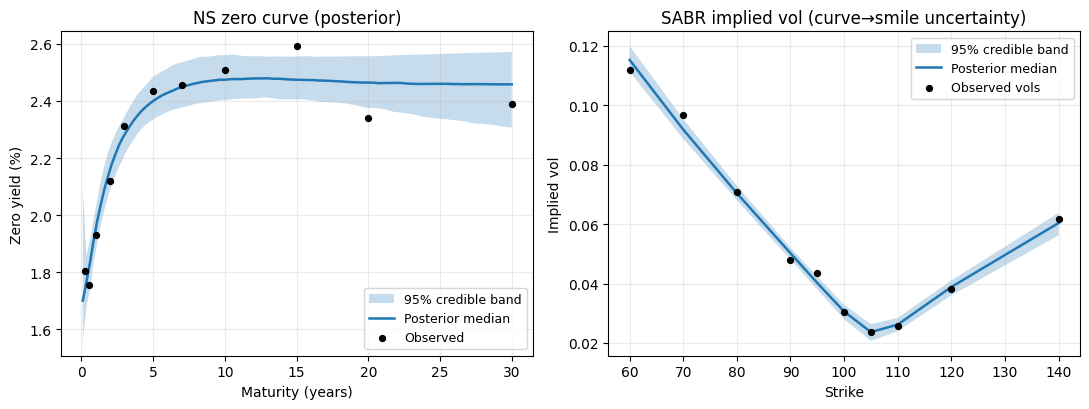

Saved figure -> /Users/matthewhosseini/Documents/PycharmProjects/PortfolioAnalysis/__BOOK/chapters/ch_bayes_sabr/codes/rates-kf-sabr-repo/outputs/figures/ns_nss_and_sabr_bayesian.png


In [7]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4.2))

# Left: curve credible band
ax[0].fill_between(tau_grid, zero_q05*100, zero_q95*100, alpha=0.25, label="95% credible band")
ax[0].plot(tau_grid, zero_q50*100, lw=1.8, label="Posterior median")
ax[0].scatter(maturities, y_obs*100, s=18, color="k", zorder=3, label="Observed")
ax[0].set_title(f"{'NSS' if use_nss else 'NS'} zero curve (posterior)")
ax[0].set_xlabel("Maturity (years)")
ax[0].set_ylabel("Zero yield (%)")
ax[0].grid(alpha=0.25)
ax[0].legend(loc="best", fontsize=9)

# Right: SABR smile credible band
ax[1].fill_between(Ks, smile_q05, smile_q95, alpha=0.25, label="95% credible band")
ax[1].plot(Ks, smile_q50, lw=1.8, label="Posterior median")
ax[1].scatter(Ks, vol_obs, s=18, color="k", zorder=3, label="Observed vols")
right_title = "SABR implied vol (parameter uncertainty)" if use_demo_data else "SABR implied vol (curve→smile uncertainty)"
ax[1].set_title(right_title)
ax[1].set_xlabel("Strike")
ax[1].set_ylabel("Implied vol")
ax[1].grid(alpha=0.25)
ax[1].legend(loc="best", fontsize=9)

plt.tight_layout() 
Path(repo_root / "outputs" / "figures").mkdir(parents=True, exist_ok=True)
out_png = str(repo_root / "outputs" / "figures" / "ns_nss_and_sabr_bayesian.png")
fig.savefig(out_png, dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"Saved figure -> {out_png}")